#Classificação de imagens de roupas

### Sobre o projeto

* Estudo introdutório sobre Deep Learning, TensorFlow e Keras.

* E-commerce fictício de roupas, as roupas à venda devem ser classificadas em categorias para facilitar as buscas dos clientes no site.

* **Dataset:** [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) que contém pequenas imagens (28x28) de roupas, associadas a 10 classes.

* **Referência:** Estudo desenvolvido acompanhando o curso [Deep Learning parte 1: Keras](https://cursos.alura.com.br/course/deep-learning-introducao-com-keras), da Alura.

# Abertura do dataset e primeiras visualizações

## Fashion MNIST

In [2]:
import tensorflow
from tensorflow import keras

dataset = keras.datasets.fashion_mnist

In [3]:
# retorna duas tuplas com conjuntos de treino, teste, e suas labels
((train_imgs, train_labels),(test_imgs, test_labels)) = dataset.load_data()

In [3]:
print(f'Conjunto de treino possui {len(train_imgs)} imagens.')
print(f'Conjunto de teste possui {len(test_imgs)} imagens.')

Conjunto de treino possui 60000 imagens.
Conjunto de teste possui 10000 imagens.


In [4]:
print(train_imgs.shape)
print(test_imgs.shape)

(60000, 28, 28)
(10000, 28, 28)


## Classes

In [5]:
import numpy as np
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

* Os nomes das classes estão no Readme do dataset.

In [6]:
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Visualização de alguns itens

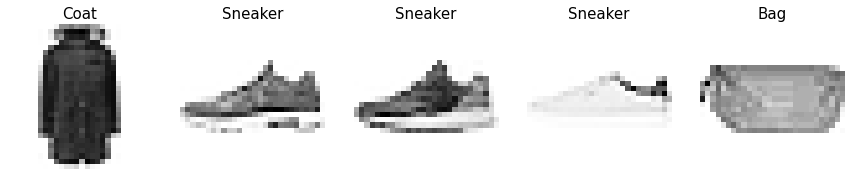

In [7]:
import random
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Greys'

fig, axs = plt.subplots(1, 5, figsize = (15, 25))

rand_ids = [random.randint(0, 60000) for i in range(5)]

for k, i in zip(range(0,5), rand_ids):
  axs[k].imshow(train_imgs[i])
  axs[k].axis('off')
  axs[k].set_title(class_name[train_labels[i]], fontsize = 15)

plt.show()

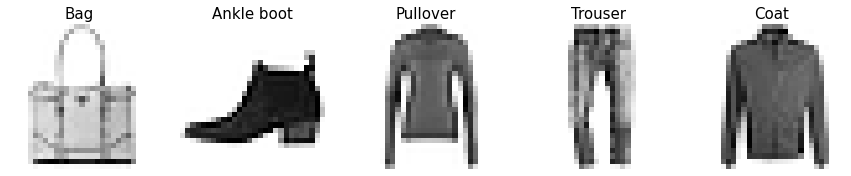

In [8]:
fig, axs = plt.subplots(1, 5, figsize = (15, 25))

rand_ids = [random.randint(0, 10000) for i in range(5)]

for k, i in zip(range(0,5), rand_ids):
  axs[k].imshow(test_imgs[i])
  axs[k].axis('off')
  axs[k].set_title(class_name[test_labels[i]], fontsize = 15)

plt.show()

# Funções de Ativação

![teste](https://miro.medium.com/max/720/1*ZafDv3VUm60Eh10OeJu1vw.webp)

## ReLu

* Todos os número negativos se tornam 0.
* A ReLu tem a possibilidade de desligar alguns neurônios.
* $a = z^+ = max(0, z)$
* É não-linear, essencial para separar mais de duas características em uma única função.

## SoftMax

* Usada da última camada.
* Atribui probabilidades de cada categoria estar correta.

* ### $a_j^{(L-1)} = \frac{exp(z_j^{(L-1)})}{∑_i exp(z_i^{(L-1)})}$

  * (L-1) ⟶ camada anterior.
  * a > 0, por do exponencial.
  * O somatório de todas as probabilidades é 1, 100%.

# Construção do Modelo

* Modelo >> entrada > processamento > saída

* Na primeira camada, Camada 0, a imagem será "achatada" para um array de pixels de uma única dimensão.

* Na Camda 1, é feita a comunicação com a camada de entrada. Neste caso, será uma camada densa, totalmente conectada com a anterior.
  * No primneiro parâmetro, são definidos quantos neurônios estarão nesta camada.É interessante utilizar múltiplos de 2 por questão de processamento.
  * Deve ser definida também a função de ativação, que neste caso será a ReLu (https://www.tensorflow.org/api_docs/python/tf/nn/relu).

* Na Camada 2, de saída, terá o número de classificações do dataset e totalmente conectada.

In [9]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),               # camada 0, entrada
    keras.layers.Dense(256, activation = tensorflow.nn.relu),   # camada 1, escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)  # camada 2, saída
])

In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

* O batch_size padrão é 32, por isso a quantidade que aparece no log não é o tamanho completo do dataset, mas sim esse valor dividido por 32. Todo o dataset é usado no treinamento, mas em grupos menores.

In [11]:
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 6s 3ms/step - loss: 4.7855


* O ideal é que a perda esteja o mais próximo de 0 possível.

# Redução de perda: Normalização

* Os pixels variam em um intervalo contínuo de 0 a 255.

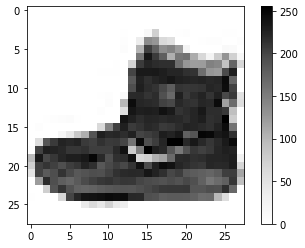

In [12]:
plt.imshow(train_imgs[0])
plt.colorbar()

* O valores serão normalizados para um intervalo de 0 a 1.

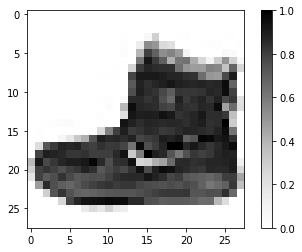

In [13]:
train_imgs = train_imgs/255.0

plt.imshow(train_imgs[0])
plt.colorbar()

# 2º Modelo: Valores normalizados [0, 1]

In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.4840


* Na execução desta observação, a perda foi reduzida de 4.4171 para 0.4825.

* Reduzir a amplitude numérica que a rede precisou processar ajudou muito a evitar perda de informação.

* As gradações das imagens se mantiveram, a roupa usada como exemplo anteriormente continuou sendo visualmente identificável, e ainda houve melhoria no modelo.

# Redução de perda: Reestruturação das camadas escondidas

* Da segunda camada para a camada de saída há conexões de 256 para 10. 

* A ideia do próximo passo é afunilar estas conexões criando uma camada internediária e verificar se a perda é reduzida.

## Segunda camada escondida: 128 neurônios

In [15]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),               # camada de entrada
    keras.layers.Dense(256, activation = tensorflow.nn.relu),   # primeira camada escondida
    keras.layers.Dense(128, activation = tensorflow.nn.relu),   # nova camda escondida, segunda camada
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)  # camada de saída
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 7s 3ms/step - loss: 0.4757


* Na execução desta observação, a perda foi reduzida de 0.4825 para 0.4777.

## Terceira camada escondida: 64 neurônios

In [16]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(64, activation = tensorflow.nn.relu),    # terceira camada escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 7s 3ms/step - loss: 0.4862


* Na execução desta observação, a perda foi incrementada de 0.4777 para 0.4854.

* Neste caso de estudo, o aumento do tempo de execução foi irrelevante.

* Aumentar a quantidade de camadas escondidas, tornando a rede mais profunda, nem sempre trará benefícios para o modelo, além de poder aumentar significativamente o tempo de execução em modelos de aplicação real.

* Tanto a quantidade de neurônios quanto as funções de ativação precisarão de uma exploração, um processo mais subjetivo do que exato.

# 3º Modelo: Normalização e 2 camadas escondidas

In [17]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels)

1875/1875 [==============================] - 7s 3ms/step - loss: 0.4789


# Redução de perda: Quantidade de épocas

* Épocas são os contatos que o modelo tem com o dataset no processo de aprendizagem, em que os ajustes de pesos das conexões são feitas entre os neurônios.

* A seguir, as quantidades de épocas serão alteradas para análise da sua influência na perda.

* O tempo de execução terá um aumento linear, diretamente proporcional à execução com somento uma época.

In [18]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4794
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3595
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3221
Epoch 4/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2991
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2801


* A perda foi diminindo gradativamente, mas mesmo neste dataset de estudo o aumento de tempo já foi perceptível.

# 4º Modelo: Normalização, 2 camadas escondidas, 5 épocas

In [19]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4766 - accuracy: 0.8274
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3597 - accuracy: 0.8667
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3267 - accuracy: 0.8794
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3007 - accuracy: 0.8872
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2842 - accuracy: 0.8938


# Métrica de avaliação: Acurácia

* A acurácia irá medir o quanto o modelo está acertando.

* O ideal é que, à medida que o modelo é reestruturado, a perda diminua e a acurácia aumente.

In [20]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_imgs, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4753 - accuracy: 0.8290
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3552 - accuracy: 0.8685
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3222 - accuracy: 0.8814
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2988 - accuracy: 0.8883
Epoch 5/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2822 - accuracy: 0.8950


* A acurácia aumentou de acordo com a quantidade de épocas executadas.

# Testes do Modelo

## Elemento a elemento

* Sobre o modelo com as aletrações: imagens normalizadas, segunda camada escondida e 5 épocas.

In [21]:
testes = model.predict(test_imgs)

313/313 [==============================] - 1s 2ms/step


In [22]:
testes[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.99999994],
      dtype=float32)

In [23]:
np.argmax(testes[0])

9

* A Softmax, usada na camada de saída, retorna a probabilidade de uma entrada pertencer a cada categoria.

* No primeiro item do dataset, demonstrado acima, foi calculada uma probabilidade de quase 100% da imagem representar um item da última classe.

In [24]:
print(f'Resultado do teste: {np.argmax(testes[0])}')
print(f'Número da imagem de teste: {test_labels[0]}')

Resultado do teste: 9
Número da imagem de teste: 9


## Evaluate

* 1º Resultados: Perda do teste
* 2º Resultado: Acurácia do teste

In [25]:
test_loss, test_accuracy = model.evaluate(test_imgs, test_labels)
print(f'Perda: {test_loss}')
print(f'Acuráci: {test_accuracy}')

313/313 [==============================] - 1s 2ms/step - loss: 62.3263 - accuracy: 0.8390
Perda: 62.3262825012207
Acuráci: 0.8389999866485596


In [26]:
test_imgs_normalized = test_imgs/255

test_loss, test_accuracy = model.evaluate(test_imgs_normalized, test_labels)
print(f'Perda: {test_loss}')
print(f'Acuráci: {test_accuracy}')

313/313 [==============================] - 1s 2ms/step - loss: 0.3464 - accuracy: 0.8765
Perda: 0.3464445471763611
Acuráci: 0.8765000104904175


## Conjunto de Validação

* Com a definição do validation_split, o treinamento passa a separar um conjunto para validação do modelo.

* Os valores de perda e acurácia da validação são retornados junto com os do treino.

In [27]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4931 - accuracy: 0.8215 - val_loss: 0.4026 - val_accuracy: 0.8534
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3679 - accuracy: 0.8643 - val_loss: 0.3697 - val_accuracy: 0.8672
Epoch 3/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3316 - accuracy: 0.8765 - val_loss: 0.3394 - val_accuracy: 0.8731
Epoch 4/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3031 - accuracy: 0.8866 - val_loss: 0.3551 - val_accuracy: 0.8717
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2892 - accuracy: 0.8917 - val_loss: 0.3317 - val_accuracy: 0.8768


# Gráficos de Acurácia e Perda

In [28]:
def plot_accuracy_loss(historico):
  fig, axs = plt.subplots(1, 2, figsize = (12, 5))

  axs[0].set_title('Acurácia por épocas', fontsize = 15)
  axs[0].set(xlabel = 'épocas', ylabel = 'perda')
  axs[0].plot(historico.history['accuracy'])
  axs[0].plot(historico.history['val_accuracy'])

  axs[1].set_title('Perda por épocas', fontsize = 15)
  axs[1].set(xlabel = 'épocas', ylabel = 'perda')
  axs[1].plot(historico.history['loss'])
  axs[1].plot(historico.history['val_loss'])

  plt.show()

## Análise de 5 épocas

In [29]:
historico.history

{'loss': [0.49307194352149963,
  0.3678533136844635,
  0.33155936002731323,
  0.3031306266784668,
  0.2892332077026367],
 'accuracy': [0.8214791417121887,
  0.8642916679382324,
  0.8764791488647461,
  0.8865833282470703,
  0.8917499780654907],
 'val_loss': [0.40260258316993713,
  0.36971667408943176,
  0.33939576148986816,
  0.35505911707878113,
  0.3317367434501648],
 'val_accuracy': [0.8534166812896729,
  0.8671666383743286,
  0.8730833530426025,
  0.871666669845581,
  0.8768333196640015]}

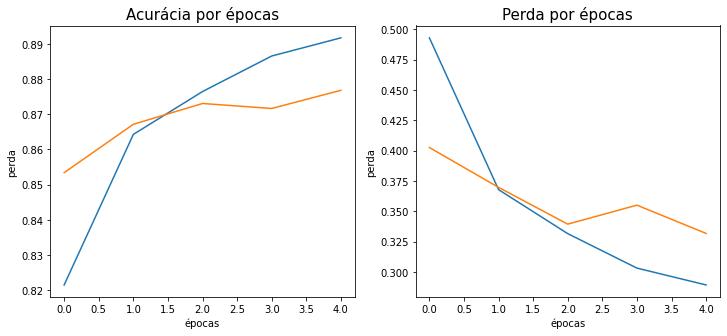

In [30]:
plot_accuracy_loss(historico)

* A acurácia aumentou no decorrer das 5 épocas. Portanto, seguiu como desejado.

* A perda diminuiu no decorrer das 5 épocas. Também seguiu como desejado.

## Análise de 10 épocas

In [31]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 10, validation_split = 0.2)

Epoch 1/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4902 - accuracy: 0.8236 - val_loss: 0.4099 - val_accuracy: 0.8538
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3669 - accuracy: 0.8658 - val_loss: 0.3686 - val_accuracy: 0.8647
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3332 - accuracy: 0.8767 - val_loss: 0.3767 - val_accuracy: 0.8606
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3064 - accuracy: 0.8844 - val_loss: 0.3352 - val_accuracy: 0.8787
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2899 - accuracy: 0.8920 - val_loss: 0.3190 - val_accuracy: 0.8837
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2709 - accuracy: 0.8967 - val_loss: 0.3284 - val_accuracy: 0.8806
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2583 - accuracy: 0.9028 - val_loss: 0.3334 - val_accuracy:

### Acurácia

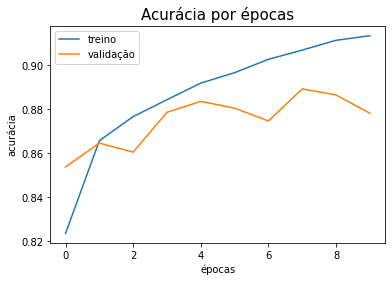

In [32]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])

plt.title('Acurácia por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])
plt.show()

* A Acurácia do treino sobe de forma consistente, mas a de validação não só não consegue aumentar o suficiente para acompanhá-la como oscila no decorrer das épocas.

### Perda

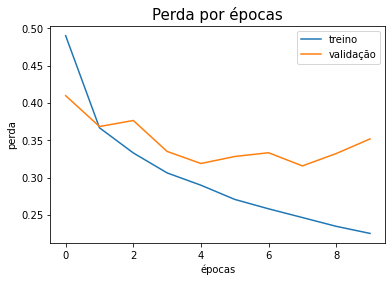

In [33]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])

plt.title('Perda por épocas', fontsize = 15)
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])
plt.show()

* Algo semelhante acontece com os valores de perda, a validação não consegue acompanhar o treino.

* Os dois gráficos sugereme o modelo está sofrendo um Overfitting, ou seja, está tão especializado nos padrões das imagens de treinamento que não consegue interpretar novas imagens, do conjunto de validação.

* Para evitar o oferfitting, pode-se manter a quantidade de épocas no intervalo em que os resultados estão mais estáveis. Onde a tendência da perda e da acurácia estão favoráveis no treino e os resultados na validação ainda estão próximos.

* Neste caso, entre [4, 6]. Será mantido o 4º modelo.

# Mais alterações nas camadas escondidas

## Dropout

* Irá inativar algumas ligações entre duas camadas, como se os neurônios estivessem inativos. Recebe uma porcentagem de ligações que serão desligadas.

* Pode ser considerado uma Normalização.

In [34]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dropout(0.2),  # nova camada escondida
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5244 - accuracy: 0.8094 - val_loss: 0.4299 - val_accuracy: 0.8349
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3899 - accuracy: 0.8570 - val_loss: 0.4073 - val_accuracy: 0.8490
Epoch 3/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3464 - accuracy: 0.8714 - val_loss: 0.3430 - val_accuracy: 0.8731
Epoch 4/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3239 - accuracy: 0.8791 - val_loss: 0.3519 - val_accuracy: 0.8722
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3039 - accuracy: 0.8878 - val_loss: 0.3224 - val_accuracy: 0.8841


### Gráficos de Validação

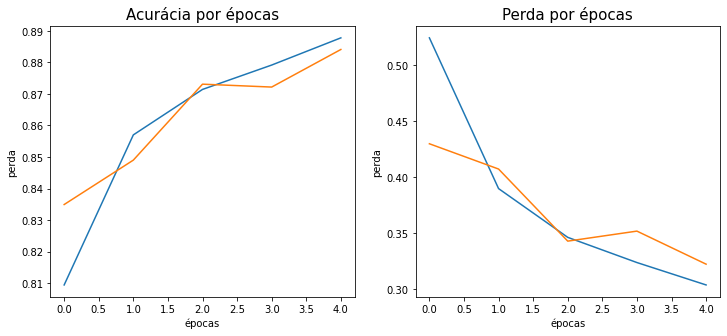

In [35]:
plot_accuracy_loss(historico)

* O comportamento das curvas de validação melhoraram em comparação com o modelo sem Dropout. Apesar dos resultados de treino serem um pouco piores, a perda e acurácia da validação estão melhores.

# Salvando e utilizando modelo treinado

In [36]:
model.save('model.h5')

In [37]:
from tensorflow.keras.models import load_model

saved_model = load_model('model.h5')

In [38]:
tests = saved_model.predict(test_imgs_normalized)
print(f'Resultado do teste: {np.argmax(tests[0])}')
print(f'Rótulo da imagem: {test_labels[0]}')

313/313 [==============================] - 1s 2ms/step
Resultado do teste: 9
Rótulo da imagem: 9


# Análises sobre o modelo e teoria

* A partir daqui, foram feitos alguns exercícios do curso para fixar conceitos relacionados a Redes Neurais. Não necessariamente têm uma aplicação prática.

## Sumário, descrição das camadas

In [39]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               200960    
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


* O Param # mostra a quantidade de parâmetros que são considerados na camada.
  * 1º há apenas o achatamento, o valor ficou 0
  * 2º (784 (achatamento 28x28) + 1 (viés)) x 256 (neurônios) 
  * 3º 256 (valores propagados da camada anterior) x 128 (neurônios) + 128 (pesos)
  * 4º Dropout 20%
  * 5º 128 (valores propagados) x 10 (neurônios) + 10 (pesos)

* Os pesos são calculadosn e otimizados nas etapas de backpropagation.

## Pesos e Vieses

### Pesos da primeira camada Dense

In [40]:
model.layers[1].get_weights()[0]

array([[-0.06120823,  0.04349517, -0.05569858, ...,  0.06058201,
        -0.07203981, -0.03120046],
       [ 0.0601459 , -0.07939421,  0.10665718, ..., -0.12965904,
        -0.05674581, -0.1038164 ],
       [-0.02151072, -0.10366576,  0.05336111, ..., -0.07552362,
         0.05814559, -0.12788932],
       ...,
       [ 0.00893271, -0.07485013,  0.09177534, ...,  0.13985595,
         0.01010508,  0.01905429],
       [ 0.10792442,  0.05917235, -0.01173389, ...,  0.23911488,
         0.0436545 ,  0.00981228],
       [ 0.00648854,  0.00710258,  0.0774351 , ...,  0.16936867,
        -0.11671699, -0.08928612]], dtype=float32)

### Vieses da primeira camada Dense

* Os Vieses indicam o que está mais próximo ou mais distante de conseguir o resultado esperado.
  * Por exemplo: uma saia está mais próxima de um vestido do que de um sapato.

In [41]:
len(model.layers[1].get_weights()[1])

256

In [42]:
model.layers[1].get_weights()[1]

array([ 2.65646428e-01, -3.64158936e-02,  2.59563863e-01, -1.59716129e-01,
        1.39424056e-02, -2.90581226e-01,  7.68650770e-02, -1.32615864e-02,
        4.88973707e-02,  2.40578204e-01,  1.21367007e-01,  2.29893446e-01,
        4.81509678e-02,  1.35396272e-01,  1.42121008e-02,  1.67943254e-01,
       -1.71077579e-01, -1.77848861e-02,  1.10644519e-01,  4.57443334e-02,
       -2.40465961e-02,  2.01073542e-01,  4.79969382e-02,  6.53483719e-02,
        1.05407856e-01,  1.67045146e-01,  2.30013832e-01, -1.53113995e-02,
       -1.45667523e-01,  1.17032737e-01, -2.41923388e-02,  3.17731202e-01,
       -1.45303654e-02,  2.21014798e-01,  2.70980388e-01, -2.00907663e-01,
        1.15536906e-01,  1.98474884e-01,  1.88754301e-03,  5.74006699e-02,
        9.35245082e-02,  6.16551042e-02,  1.48854777e-01, -8.08710009e-02,
        1.42414674e-01, -6.19825162e-03,  7.39758043e-03, -1.73675716e-02,
       -2.64868643e-02, -2.12067012e-02, -3.88643146e-02,  2.22053573e-01,
       -5.46136759e-02,  

### Alterando pesos "à mão"

#### Pesos 0

In [43]:
vieses_camada_dense = model.layers[1].get_weights()[1]
print(f'Vieses: {vieses_camada_dense.shape}')
pesos_camada_dense = model.layers[1].get_weights()[0]
print(f'Pesos: {pesos_camada_dense.shape}')

Vieses: (256,)
Pesos: (784, 256)


In [44]:
pesos_camada_dense_zerados = np.zeros((784, 256))
model.layers[1].set_weights([pesos_camada_dense_zerados, vieses_camada_dense])

In [45]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5324 - accuracy: 0.8050 - val_loss: 0.4074 - val_accuracy: 0.8508
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3881 - accuracy: 0.8567 - val_loss: 0.3783 - val_accuracy: 0.8554
Epoch 3/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3537 - accuracy: 0.8682 - val_loss: 0.3468 - val_accuracy: 0.8713
Epoch 4/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3285 - accuracy: 0.8781 - val_loss: 0.3730 - val_accuracy: 0.8630
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3097 - accuracy: 0.8844 - val_loss: 0.3325 - val_accuracy: 0.8795


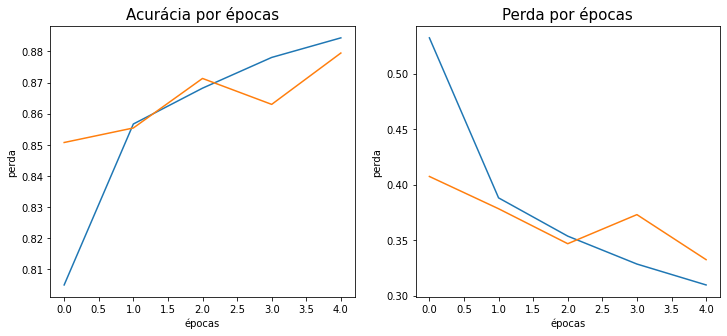

In [46]:
plot_accuracy_loss(historico)

#### Pesos aleatórios

In [47]:
pesos_camada_dense_aleatorios = np.random.rand(784, 256)
model.layers[1].set_weights([pesos_camada_dense_aleatorios, vieses_camada_dense])

In [48]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 6s 4ms/step - loss: 24.5102 - accuracy: 0.2682 - val_loss: 1.5147 - val_accuracy: 0.4160
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 1.6390 - accuracy: 0.3654 - val_loss: 1.3401 - val_accuracy: 0.4958
Epoch 3/5
1500/1500 [==============================] - 6s 4ms/step - loss: 1.6251 - accuracy: 0.3824 - val_loss: 1.3133 - val_accuracy: 0.5143
Epoch 4/5
1500/1500 [==============================] - 6s 4ms/step - loss: 1.8546 - accuracy: 0.3042 - val_loss: 1.7518 - val_accuracy: 0.3166
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 1.9274 - accuracy: 0.2449 - val_loss: 1.7109 - val_accuracy: 0.3275


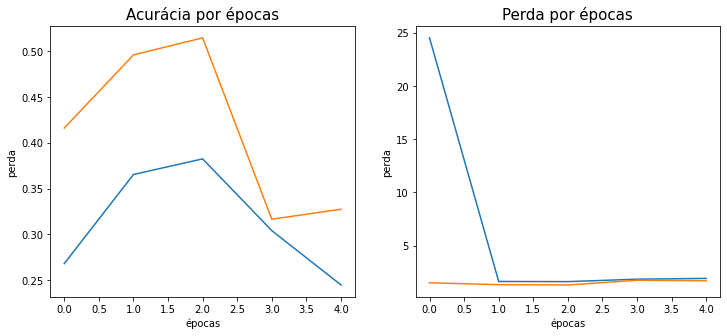

In [49]:
plot_accuracy_loss(historico)

### Alterando vieses "à mão"

#### Vieses e Pesos 0

In [50]:
vieses_camada_dense_zerados = np.zeros((256,))
model.layers[1].set_weights([pesos_camada_dense_zerados, vieses_camada_dense_zerados])

In [51]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

Epoch 1/5
1500/1500 [==============================] - 7s 4ms/step - loss: 2.3457 - accuracy: 0.0990 - val_loss: 2.3047 - val_accuracy: 0.1003
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 2.3117 - accuracy: 0.1010 - val_loss: 2.3034 - val_accuracy: 0.0983
Epoch 3/5
1500/1500 [==============================] - 6s 4ms/step - loss: 2.3097 - accuracy: 0.1001 - val_loss: 2.3068 - val_accuracy: 0.0983
Epoch 4/5
1500/1500 [==============================] - 7s 5ms/step - loss: 2.3072 - accuracy: 0.0983 - val_loss: 2.3031 - val_accuracy: 0.0995
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 2.3062 - accuracy: 0.1002 - val_loss: 2.3030 - val_accuracy: 0.0957


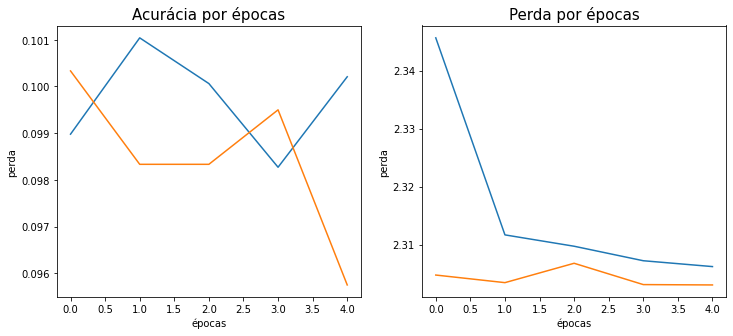

In [52]:
plot_accuracy_loss(historico)

#### Vieses 0 e Pesos aleatórios

Epoch 1/5
1500/1500 [==============================] - 7s 4ms/step - loss: 2.3795 - accuracy: 0.0983 - val_loss: 2.3227 - val_accuracy: 0.0983
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 2.3085 - accuracy: 0.1008 - val_loss: 2.3031 - val_accuracy: 0.0983
Epoch 3/5
1500/1500 [==============================] - 6s 4ms/step - loss: 2.3028 - accuracy: 0.1001 - val_loss: 2.3029 - val_accuracy: 0.0995
Epoch 4/5
1500/1500 [==============================] - 6s 4ms/step - loss: 2.3027 - accuracy: 0.1007 - val_loss: 2.3028 - val_accuracy: 0.0983
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 2.3028 - accuracy: 0.1004 - val_loss: 2.3027 - val_accuracy: 0.0983


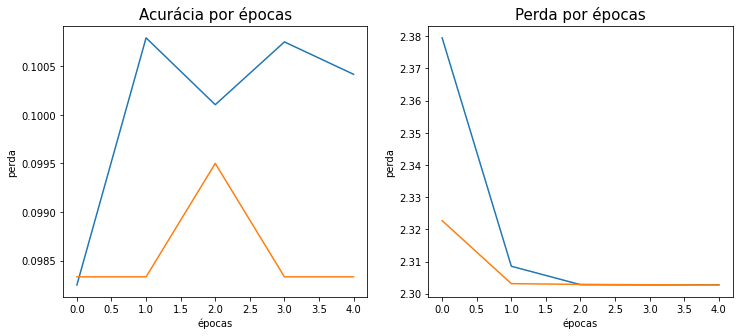

In [53]:
vieses_camada_dense_zerados = np.zeros((256,))
model.layers[1].set_weights([pesos_camada_dense_aleatorios, vieses_camada_dense_zerados])

model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2)

plot_accuracy_loss(historico)

### Configurações do modelo

* **model.get_config()**: Retorna dicionários com todas as definições da rede e suas camadas.

In [54]:
model.get_config()['layers'][2]

{'class_name': 'Dense',
 'config': {'name': 'dense_29',
  'trainable': True,
  'dtype': 'float32',
  'units': 256,
  'activation': 'relu',
  'use_bias': True,
  'kernel_initializer': {'class_name': 'GlorotUniform',
   'config': {'seed': None}},
  'bias_initializer': {'class_name': 'Zeros', 'config': {}},
  'kernel_regularizer': None,
  'bias_regularizer': None,
  'activity_regularizer': None,
  'kernel_constraint': None,
  'bias_constraint': None}}

* O kernel_initializes é a função inicializa os pesos.

* A classe de inicialização dos pesos nesta rede foi a GlorotUniform, também chamada de Algoritmo de Xavier. Gera valores que não sejam nem muito grandes nem muito próximos de zero, de forma que evite atrapalhar a aprendizagem do modelo.

* A ReLu também azjuda a evitar valores extremos.

### Conclusões sobre Pesos e Vieses

* Os pesos influenciam mais no quanto uma rede aprende do que os vieses.
  * Os resultados foram piores quando os pesos foram inicializados aleatoriamente.

* É mais indicado inicializar os pesos de uma rede com zeros ou valores próximos de zero.

* O **bias_initializer** define como os pesos são inicializados. Na consulta acima, está definindo como 'Zeros', que é o padrão do Keras.

## Função ReLu

* $a = z^+ = max(0, z)$

* Não linear.

* A multiplicação da fução ReLu altera a inclinação da sua reta no 1º quadrante (x, y > 0).
* A soma desloca as retas no eixo y.

# Explorando hisperparâmetros do Otimizador (Adam)

* https://keras.io/api/optimizers/adam/

In [9]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

adam = keras.optimizers.Adam(learning_rate = 0.002) 

model.compile(optimizer = adam, 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
historico = model.fit(train_imgs, train_labels, epochs = 5, validation_split = 0.2, batch_size = 480)

Epoch 1/5
100/100 [==============================] - 2s 17ms/step - loss: 8.3258 - accuracy: 0.5569 - val_loss: 0.8610 - val_accuracy: 0.6955
Epoch 2/5
100/100 [==============================] - 2s 15ms/step - loss: 0.9529 - accuracy: 0.6524 - val_loss: 0.7692 - val_accuracy: 0.7042
Epoch 3/5
100/100 [==============================] - 1s 15ms/step - loss: 0.8496 - accuracy: 0.6791 - val_loss: 0.6889 - val_accuracy: 0.7285
Epoch 4/5
100/100 [==============================] - 2s 15ms/step - loss: 0.7772 - accuracy: 0.6934 - val_loss: 0.6769 - val_accuracy: 0.7322
Epoch 5/5
100/100 [==============================] - 2s 15ms/step - loss: 0.7350 - accuracy: 0.7050 - val_loss: 0.6292 - val_accuracy: 0.7472


* Aumentar o **learning_rate** fez a perda ficar muito alta na primeira época.

In [12]:
callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss'),
             keras.callbacks.ModelCheckpoint(filepath = 'modelo.hdf5', monitor = 'val_loss', save_best_only = True)]
adam = keras.optimizers.Adam(learning_rate = 0.002) 

model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(256, activation = tensorflow.nn.relu),
    keras.layers.Dense(128, activation = tensorflow.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation = tensorflow.nn.softmax)
])

model.compile(optimizer = adam, 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

historico = model.fit(train_imgs, train_labels, 
                      epochs = 5, validation_split = 0.2, 
                      batch_size = 480,
                      callbacks = callbacks)

Epoch 1/5
100/100 [==============================] - 2s 18ms/step - loss: 13.2165 - accuracy: 0.5944 - val_loss: 0.8516 - val_accuracy: 0.7060
Epoch 2/5
100/100 [==============================] - 2s 16ms/step - loss: 0.9152 - accuracy: 0.6798 - val_loss: 0.7217 - val_accuracy: 0.7351


* As épocas param de ser executadas mais cedo porque as alterações em alguma das taxas deixam de ser significativas. Entretanto, o algoritmo pode ter estacionado em um mínimo local e não ter mais como acessar o mínimo global (valor ótimo, neste caso).